# Freesound 2019 Audio Tagging Challenge
Zach Neveu

## TODO
1. Write clip lengths in a file to cache
2. Check how often lwlrap runs - worth moving to the gpu?

In [1]:
import fastai
fastai.__version__

'1.0.51'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai_audio import *

In [4]:
DATA = Path('/home/zach/Data/FS2019')
clean_folder = DATA/"train_curated"
noisy_folder = DATA/"train_noisy"

In [5]:
clean_labels = pd.read_csv(DATA/'train_curated.csv')
noisy_labels = pd.read_csv(DATA/'train_noisy.csv')

## Get number of classes

In [6]:
clean_list = clean_labels['labels'].tolist()
split = [x.split(',') for x in clean_list]
flatten = lambda l: [ item for sublist in l for item in sublist]
len(set(flatten(split)))

80

In [7]:
classes = set(flatten(split))

# Visualize some Mel Spectrograms

In [33]:
import librosa
import librosa.display
from IPython import display as ipd
from random import randint

In [34]:
import torchaudio as ta
import torchaudio.transforms as tatfms

In [35]:
def spec(fn):
    y, sr = librosa.load(fn)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                            y_axis='mel', fmax=20000,
                            x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram of '+str(fn))
    plt.tight_layout()
    display(ipd.Audio(str(fn)))

['Motorcycle']

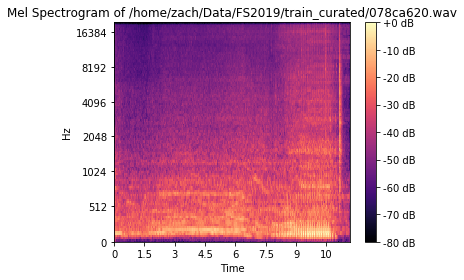

In [36]:
fn = clean_folder/clean_labels["fname"][randint(1, 1000)]
spec(fn)
getCleanLabel(fn)

In [ ]:
#fn = clean_folder/clean_labels["fname"][randint(1, 1000)]
a, sr = ta.load(fn)
spectfm = tatfms.Compose([
    tatfms.MelSpectrogram(sr=sr, n_mels=128, n_fft=2048, hop=512),
    tatfms.SpectrogramToDB()
    ])
specg = spectfm(a).squeeze(0).transpose(0,1)
nparr = specg.cpu().numpy()
librosa.display.specshow(nparr)

# Training Setup
lwlrap loss function from the provided Colab notebook

In [8]:
# Calculate the overall lwlrap using sklearn.metrics function.
import sklearn.metrics
def lwrap(pred, targ):
  t = targ.cpu().numpy()
  p = pred.cpu().numpy()
  """Calculate the overall lwlrap using sklearn.metrics.lrap."""
  # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
  sample_weight = np.sum(t > 0, axis=1)
  nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
  overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      t[nonzero_weight_sample_indices, :] > 0, 
      p[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
  torch_ver = torch.from_numpy(np.asarray(overall_lwlrap.astype(np.float32))).cuda()
  return torch_ver

lwlrap = AverageMetric(lwrap)

Set up Transforms to spectrograms. Settings largely copied from default librosa settings because these produced good visual results.

In [9]:
n_fft = 2048 # output of fft will have shape [513 x n_frames]
n_hop = 512  # 75% overlap between frames
n_mels = 128 # compress 513 dimensions to 40 via mel frequency scale
sample_rate = 44100
bs=24

tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                      n_mels=n_mels, sample_rate=sample_rate)

# Train Resnet18 on Noisy Data to Learn Representations

In [10]:
def getNoisyLabel(fn):
    idx = noisy_labels.index[noisy_labels['fname'] == fn.name].tolist()
    labs =  noisy_labels["labels"][idx[0]].split(',')
    return labs

Next cell takes awhile. Clips are not the same length, so `fastai_audio` makes use of `fastai`'s sortish sampler to put similar length clips in the same batch and minimize padding side effects. Downside of this is that sorting by length is considerably slower than $O(n)$ it seems...

In [11]:
%%time
noisy_data = (AudioItemList
       .from_folder(noisy_folder, recurse=False, extensions='.wav')
       .split_by_rand_pct()
       .label_from_func(getNoisyLabel)
       .databunch(bs=bs, tfms=tfms, equal_lengths=False, num_workers=8))

Beginning calculations...
Train lengths calculated...
Valid lengths calculated...
Fix Lengths calculated...
CPU times: user 3min 5s, sys: 41.1 s, total: 3min 46s
Wall time: 19min 51s


In [12]:
noisy_data.save('noisy_data_bs16')

In [13]:
learn = create_cnn(noisy_data, models.resnet18, pretrained=False, metrics=[lwlrap])

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(8, slice(1e-5, 1e-2))

KeyboardInterrupt: 

In [16]:
learn.save('noisy_3epochs')

In [17]:
learn.export()

# Train Resnet18 on Clean Data

In [11]:
def getCleanLabel(fn):
    idx = clean_labels.index[clean_labels['fname'] == fn.name].tolist()
    labs =  clean_labels["labels"][idx[0]].split(',')
    return labs

In [13]:
%%time
data = (AudioItemList
       .from_folder(clean_folder, recurse=False, extensions='.wav')
       .split_by_rand_pct()
       .label_from_func(getCleanLabel)
       .add_test_folder(DATA/'test')
       .databunch(bs=bs, tfms=tfms, equal_lengths=False, num_workers=8))

Beginning calculations...
Train lengths calculated...
Valid lengths calculated...
Fix Lengths calculated...
CPU times: user 6.78 s, sys: 947 ms, total: 7.73 s
Wall time: 7.66 s


In [14]:
learn = create_cnn(data, models.resnet18, pretrained=False, metrics=[lwlrap])

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [47]:
learn.fit_one_cycle(10, slice(1e-5, 1e-2))

In [17]:
learn = load_learner(clean_folder)

# Test Set

In [20]:
test_folder = DATA/'test'

In [21]:
test_df = pd.read_csv(DATA/'sample_submission.csv')

In [22]:
test_set = AudioItemList.from_df(test_df, DATA, col='fname', folder='test')

In [42]:
AudioItemList.from_folder?

Signature:
AudioItemList.from_folder(
    ['path: Union[pathlib.Path, str]', 'extensions: Collection[str] = None', 'recurse: bool = True', 'include: Union[Collection[str], NoneType] = None', 'processor: Union[fastai.data_block.PreProcessor, Collection[fastai.data_block.PreProcessor]] = None', '**kwargs'],
) -> 'ItemList'
Docstring:
Create an `ItemList` in `path` from the filenames that have a suffix in `extensions`.
`recurse` determines if we search subfolders.
File:      ~/anaconda3/lib/python3.7/site-packages/fastai/data_block.py
Type:      method


In [ ]:
test_set.split_by_fname_file

In [24]:
data.add_test(test_set)

In [25]:
data.test_ds

LabelList (1120 items)
x: AudioItemList
(duration=0.4s, sample_rate=44.1KHz),(duration=16.06s, sample_rate=44.1KHz),(duration=4.72s, sample_rate=44.1KHz),(duration=19.0s, sample_rate=44.1KHz),(duration=22.88s, sample_rate=44.1KHz)
y: EmptyLabelList
,,,,
Path: /home/zach/Data/FS2019/train_curated

In [26]:
learn = load_learner(clean_folder)

In [27]:
learn.data = data

In [47]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

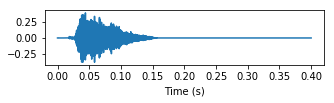

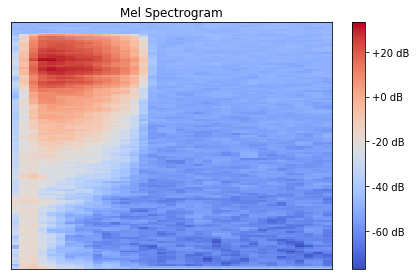

In [38]:
test_set[0].show()

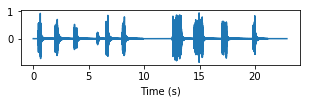

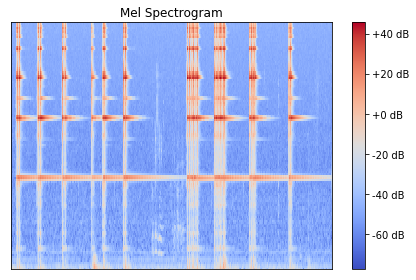

In [45]:
data.test_ds.x[4].show()

In [30]:
f1 = os.listdir(DATA/'test')[0]

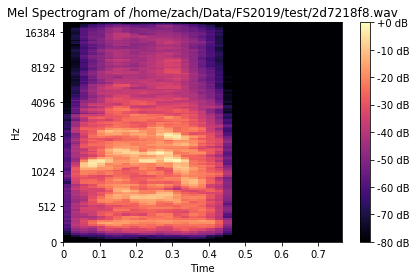

In [37]:
spec(DATA/'test'/f1)

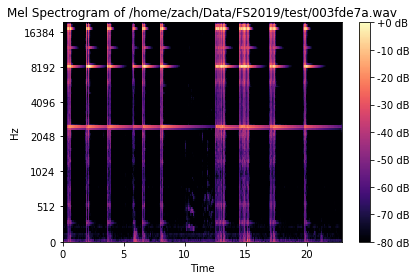

In [46]:
spec(DATA/('test/'+test_df['fname'][4]))

In [48]:
test_df[list(classes)] = preds

In [49]:
test_df.to_csv(DATA/'submission.csv')